In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
import unittest
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
import pickle
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torchvision.transforms as T  # Тут лежит Compose

# Оптимизатор - стохастический градиентный спуск

In [2]:
class MySGD:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            param.grad = None if param.grad is None else param.grad.zero_()


# Модель для задачи мультирегрессии

## EDA

Цель - наилучшим способом предсказать цену брильянта. \
price: цена в usd \
carat: вeс в каратах \
cut: качество огранки (Fair, Good, Very Good, Premium, Ideal) \
color: цветность брильянта (степень "желтезны"), от J (плохая) до D (наилучшая) https://en.wikipedia.org/wiki/Diamond_color \
clarity: чистота бриллианта (I1 (плохая), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (наилучшая)) https://en.wikipedia.org/wiki/Diamond_clarity \
x: длинна в мм \
y: ширина в мм \
z: глубина в мм \
depth: общий процент глубины = z / mean(x, y) = 2 * z / (x + y) \
table: ширина вершины ромба относительно самого широкого места

будем предсказывать price и carat

In [3]:
path_train = 'train.csv'

In [7]:
# Раскомментировать для колаба

from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [10]:
df = pd.read_csv(path_train)

In [11]:
def classify_columns(df):
    numeric_columns = []
    categorical_columns = []

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            numeric_columns.append(column)
        else:
            categorical_columns.append(column)

    return numeric_columns, categorical_columns

numeric_columns, categorical_columns = classify_columns(df)

print("Числовые колонки:", numeric_columns)
print("Категориальные колонки:", categorical_columns)

Числовые колонки: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
Категориальные колонки: ['cut', 'color', 'clarity']


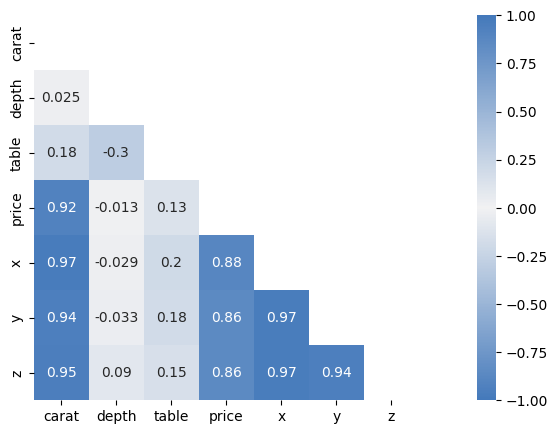

In [12]:
corr = df.drop(['cut', 'color', 'clarity'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corr,
    mask=mask,
    cmap=sns.diverging_palette(250, 250, as_cmap=True),
    annot = True,
    vmin=-1.0, vmax=1.0, # всегда ставить от -1 до 1 ставим два одинаковых цвета на оба конца
    square=True,
    ax=ax);

In [13]:
df = pd.read_csv(path_train)

df = df.drop_duplicates()

df.loc[df['x'] <= 0, 'x'] = np.nan
df.loc[df['y'] <= 0, 'y'] = np.nan
df.loc[df['z'] <= 0, 'z'] = np.nan
df.loc[df['carat'] <= 0, 'carat'] = np.nan
df.loc[df['depth'] <= 0, 'depth'] = np.nan
df.loc[df['table'] <= 0, 'table'] = np.nan
df.loc[df['x'] > 20, 'x'] /= 10
df.loc[df['y'] > 20, 'y'] /= 10
df.loc[df['z'] > 20, 'z'] /= 10
df['depth'] = round(2 * df['z'] / (df['x'] + df['y']) * 100, 1)

In [14]:
print("Размерность датафрейма:")
print(df.shape)
print()
missing_values_count = df.isna().sum()  # Общее количество пропущенных значений
missing_values_percentage = (df.isna().mean() * 100).round(2)  # Процент пропущенных значений
unique_values_count = df.nunique()  # Количество уникальных значений в каждом столбце

missing_summary = pd.DataFrame({
    'Missing Values Count': missing_values_count,
    'Missing Values Percentage': missing_values_percentage,
    'Unique Values Count': unique_values_count
})

print("Сводка по отсутствующим значениям и уникальным значениям:")
print(missing_summary)

Размерность датафрейма:
(40377, 10)

Сводка по отсутствующим значениям и уникальным значениям:
         Missing Values Count  Missing Values Percentage  Unique Values Count
carat                       0                       0.00                  269
cut                         0                       0.00                    5
color                       0                       0.00                    7
clarity                     0                       0.00                    8
depth                      13                       0.03                  182
table                       0                       0.00                  119
price                       0                       0.00                10397
x                           7                       0.02                  545
y                           6                       0.01                  538
z                          13                       0.03                  367


In [15]:
df = df.dropna()

In [16]:
X = df.drop(['price', 'carat'], axis=1)
y = df[['price', 'carat']]

cat_features = ['cut', 'color', 'clarity']
axis_features = ['x', 'y', 'z', 'table', 'depth']

axis_transformer = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=np.nan, max_iter=20)),
    ('polynom', PolynomialFeatures(2, include_bias=False)),
    ('scaler', RobustScaler())
])

cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

CT = ColumnTransformer([
    ("axis_transformer", axis_transformer, axis_features),
    ("cat", cat, cat_features)
]).set_output(transform='pandas')

In [17]:
class DiamondDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

CT.fit(X_train)

X_train = CT.transform(X_train)
X_val = CT.transform(X_val)
X_test = CT.transform(X_test)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

Train size: (27447, 40), Val size: (6862, 40), Test size: (6055, 40)


In [19]:
batch_size_train = 128
batch_size_val = 128
batch_size_test = 512

train_dataset = DiamondDataset(X_train, y_train)
test_dataset = DiamondDataset(X_test, y_test)
val_dataset = DiamondDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

**Добавляю: \
шедулер для lr \
вормап \
механизм ранней остановки и сохранение лучшей модели. \
Свитч лося (метрики) и оптимайзера.**

## Маленькая модель

In [20]:
class DiamondNetSmall(nn.Module):
    def __init__(self, input_size):
        super(DiamondNetSmall, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 2 выхода: price и carat
        )

    def forward(self, x):
        return self.net(x)


In [21]:
input_size = X_train.shape[1]
num_epochs = 100
patience = 20

loss_functions = {
    "mse": nn.MSELoss(),
    "huber": nn.HuberLoss(),
    "smooth_l1": nn.SmoothL1Loss()
}

optimizers = {
    "adam": lambda params: torch.optim.Adam(params, lr=0.001),
    "sgd": lambda params: torch.optim.SGD(params, lr=0.001, momentum=0.9),
    "rmsprop": lambda params: torch.optim.RMSprop(params, lr=0.001)
}

loss_choice = "mse"
optimizer_choice = "adam"

criterion = loss_functions[loss_choice]
model = DiamondNetSmall(input_size)
optimizer = optimizers[optimizer_choice](model.parameters())

warmup_epochs = 5
base_lr = 0.001

def warmup_fn(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_fn)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.75)

# --- Early Stopping ---
best_val_loss = float("inf")
epochs_no_improve = 0
best_model_path = "best_model.pth"


In [22]:
train_losses, val_losses, lrs = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    lrs.append(optimizer.param_groups[0]["lr"])

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        step_scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.2f}, Val Loss: {epoch_val_loss:.4f}, LR: {lrs[-1]:.6f}')

Epoch [10/100], Train Loss: 317977.98, Val Loss: 284805.4938, LR: 0.001000
Epoch [20/100], Train Loss: 226287.90, Val Loss: 227362.0959, LR: 0.001000
Epoch [30/100], Train Loss: 197896.31, Val Loss: 191696.2500, LR: 0.000750
Epoch [40/100], Train Loss: 187900.93, Val Loss: 188126.5485, LR: 0.000750
Epoch [50/100], Train Loss: 179880.87, Val Loss: 181871.9439, LR: 0.000563
Epoch [60/100], Train Loss: 177306.51, Val Loss: 177973.6674, LR: 0.000563
Epoch [70/100], Train Loss: 175306.00, Val Loss: 178088.1853, LR: 0.000422
Epoch [80/100], Train Loss: 173458.77, Val Loss: 174892.3549, LR: 0.000422
Epoch [90/100], Train Loss: 170724.98, Val Loss: 172995.0714, LR: 0.000316
Epoch [100/100], Train Loss: 170928.32, Val Loss: 172603.4667, LR: 0.000316


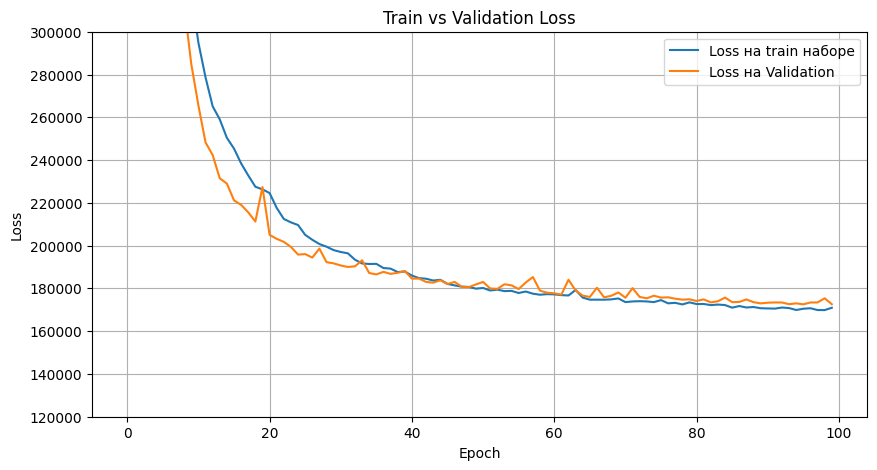

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Loss на train наборе')
plt.plot(val_losses, label='Loss на Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(120000, 300000)
plt.legend()
plt.title('Train vs Validation Loss')
plt.grid()
plt.show()

## Средняя модель

In [24]:
class DiamondNetMedium(nn.Module):
    def __init__(self, input_size):
        super(DiamondNetMedium, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)

In [25]:
input_size = X_train.shape[1]
num_epochs = 100
patience = 20

loss_functions = {
    "mse": nn.MSELoss(),
    "huber": nn.HuberLoss(),
    "smooth_l1": nn.SmoothL1Loss()
}

optimizers = {
    "adam": lambda params: torch.optim.Adam(params, lr=0.001),
    "sgd": lambda params: torch.optim.SGD(params, lr=0.001, momentum=0.9),
    "rmsprop": lambda params: torch.optim.RMSprop(params, lr=0.001)
}

loss_choice = "mse"
optimizer_choice = "adam"

criterion = loss_functions[loss_choice]
model = DiamondNetMedium(input_size)
optimizer = optimizers[optimizer_choice](model.parameters())

warmup_epochs = 5
base_lr = 0.001

def warmup_fn(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_fn)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.75)

best_val_loss = float("inf")
epochs_no_improve = 0
best_model_path = "best_model.pth"


In [26]:
train_losses, val_losses, lrs = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    lrs.append(optimizer.param_groups[0]["lr"])

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        step_scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.2f}, Val Loss: {epoch_val_loss:.4f}, LR: {lrs[-1]:.6f}')

Epoch [10/100], Train Loss: 243371.63, Val Loss: 223860.4437, LR: 0.001000
Epoch [20/100], Train Loss: 189953.48, Val Loss: 185175.5679, LR: 0.001000
Epoch [30/100], Train Loss: 174845.05, Val Loss: 173876.7024, LR: 0.000750
Epoch [40/100], Train Loss: 169635.46, Val Loss: 166488.8365, LR: 0.000750
Epoch [50/100], Train Loss: 163873.99, Val Loss: 166062.6313, LR: 0.000563
Epoch [60/100], Train Loss: 161526.39, Val Loss: 170088.6791, LR: 0.000563
Epoch [70/100], Train Loss: 155778.39, Val Loss: 160376.9067, LR: 0.000422
Epoch [80/100], Train Loss: 154729.49, Val Loss: 157177.4909, LR: 0.000422
Epoch [90/100], Train Loss: 150896.73, Val Loss: 158547.6098, LR: 0.000316
Epoch [100/100], Train Loss: 147677.59, Val Loss: 154390.8587, LR: 0.000316


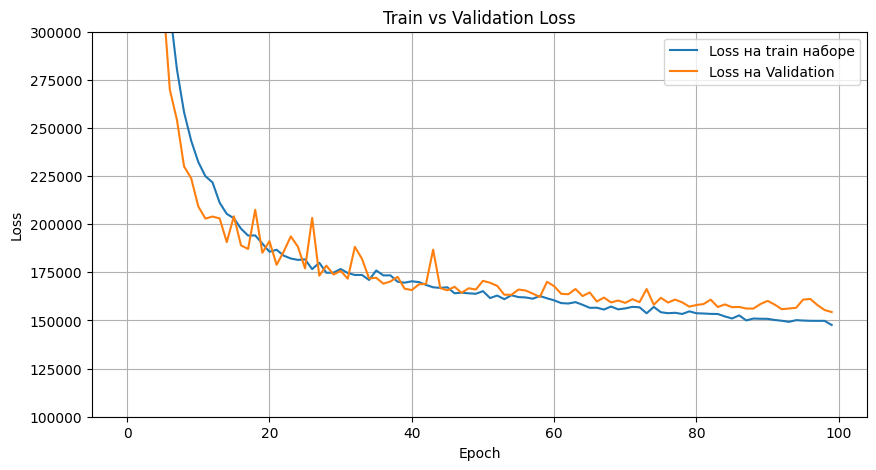

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Loss на train наборе')
plt.plot(val_losses, label='Loss на Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(100000, 300000)
plt.legend()
plt.title('Train vs Validation Loss')
plt.grid()
plt.show()

In [28]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 156869.1992


## Большая модель

In [29]:

class DiamondNeLarge(nn.Module):
    def __init__(self, input_size):
        super(DiamondNeLarge, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)

In [30]:
input_size = X_train.shape[1]
num_epochs = 100
patience = 20

loss_functions = {
    "mse": nn.MSELoss(),
    "huber": nn.HuberLoss(),
    "smooth_l1": nn.SmoothL1Loss()
}

optimizers = {
    "adam": lambda params: torch.optim.Adam(params, lr=0.001),
    "sgd": lambda params: torch.optim.SGD(params, lr=0.001, momentum=0.9),
    "rmsprop": lambda params: torch.optim.RMSprop(params, lr=0.001)
}

loss_choice = "mse"  # Можно менять тут
optimizer_choice = "adam"  # И тут

criterion = loss_functions[loss_choice]
model = DiamondNeLarge(input_size)
optimizer = optimizers[optimizer_choice](model.parameters())

warmup_epochs = 5
base_lr = 0.001

def warmup_fn(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_fn)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.75)

best_val_loss = float("inf")
epochs_no_improve = 0
best_model_path = "best_model.pth"


In [31]:
train_losses, val_losses, lrs = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    lrs.append(optimizer.param_groups[0]["lr"])

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # Сохраняем лучшую модель
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        step_scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.2f}, Val Loss: {epoch_val_loss:.4f}, LR: {lrs[-1]:.6f}')

Epoch [10/100], Train Loss: 199329.89, Val Loss: 243465.5543, LR: 0.001000
Epoch [20/100], Train Loss: 190996.05, Val Loss: 174689.3306, LR: 0.001000
Epoch [30/100], Train Loss: 159963.21, Val Loss: 164513.7160, LR: 0.000750
Epoch [40/100], Train Loss: 156437.65, Val Loss: 163850.0761, LR: 0.000750
Epoch [50/100], Train Loss: 146002.75, Val Loss: 162012.1735, LR: 0.000563
Epoch [60/100], Train Loss: 137740.97, Val Loss: 168722.8063, LR: 0.000563
Epoch [70/100], Train Loss: 128904.83, Val Loss: 177404.0817, LR: 0.000422
Epoch [80/100], Train Loss: 121928.27, Val Loss: 157584.8197, LR: 0.000422
Epoch [90/100], Train Loss: 116925.61, Val Loss: 156109.7410, LR: 0.000316
Early stopping at epoch 99


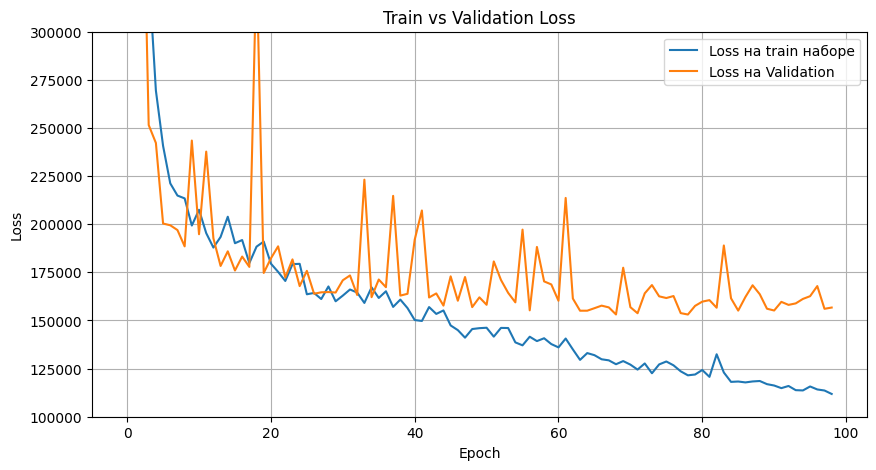

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Loss на train наборе')
plt.plot(val_losses, label='Loss на Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(100000, 300000)
plt.legend()
plt.title('Train vs Validation Loss')
plt.grid()
plt.show()

In [33]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 154299.2826


# Мультиклассификация MNIST

In [34]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    'MNIST', train=True, download=True, transform=transform
)
val_dataset = torchvision.datasets.MNIST(
    'MNIST', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1024, shuffle=False, num_workers=4
)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [35]:
images, labels = next(iter(train_loader))

In [36]:
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

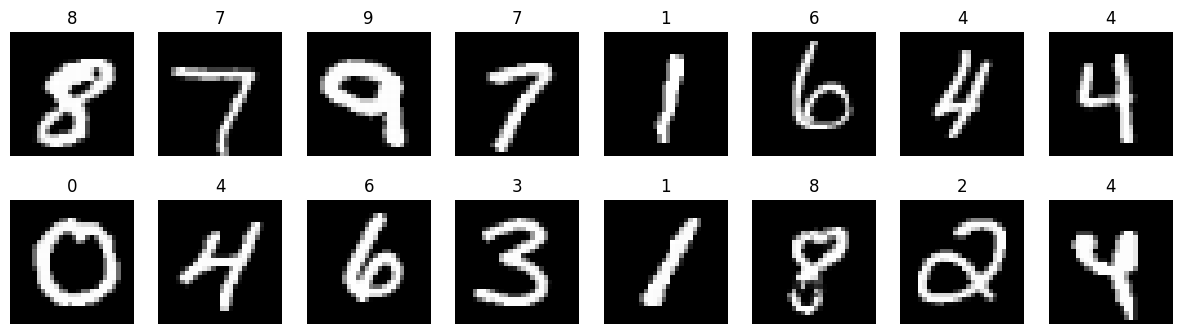

In [37]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(images[k], (1, 2, 0)), cmap='gray')
        ax.set_title(labels[k].item())
        k += 1
plt.show()

In [38]:
train_dataset = torchvision.datasets.MNIST(root='MNIST', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='MNIST', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=4)

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
device

device(type='cuda')

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), "cnn_mnist.pth")
print("Model saved!")

Epoch [1/10], Train Loss: 1.5609, Val Accuracy: 97.64%
Epoch [2/10], Train Loss: 1.4881, Val Accuracy: 98.50%
Epoch [3/10], Train Loss: 1.4830, Val Accuracy: 98.63%
Epoch [4/10], Train Loss: 1.4792, Val Accuracy: 98.65%
Epoch [5/10], Train Loss: 1.4779, Val Accuracy: 98.71%
Epoch [6/10], Train Loss: 1.4761, Val Accuracy: 98.77%
Epoch [7/10], Train Loss: 1.4753, Val Accuracy: 98.53%
Epoch [8/10], Train Loss: 1.4753, Val Accuracy: 98.76%
Epoch [9/10], Train Loss: 1.4736, Val Accuracy: 98.95%
Epoch [10/10], Train Loss: 1.4725, Val Accuracy: 99.08%
Model saved!


**Пробовал менять архитектуру, в итоге все колеблется около 99% \
Получилось стабилизовать более менее обучение за счет Dropout**